In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial

In [2]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [3]:
K.set_image_dim_ordering('tf')
print(K.image_data_format())

channels_last


In [4]:
def get_unet(size, n_cls):
    inputs = Input((size, size, 3))
    
    conv1 = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)

    conv10 = Conv2D(n_cls, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

In [5]:
class BatchGenerator:

    @staticmethod
    def to_one_hot(img, n_cls):
        return (np.arange(n_cls) == img[:, :, None]).astype(int)
    
    def __init__(self, txt_filepath, size, n_cls, batch_size):
        self.lines = []
        for line in open(txt_filepath, 'r').readlines():
            line = line.strip()
            if len(line) > 0:
                self.lines.append(line)
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_sample(self):
        if self.i == 0:
            random.shuffle(self.lines)
        orig_filepath, gt_filepath = self.lines[self.i].split()
        orig = cv2.imread(orig_filepath) # 1 and 3 channels swapped
        orig = cv2.resize(orig, (size, size))
        gt = cv2.imread(gt_filepath)[:, :, 0]
        gt = cv2.resize(gt, (self.size, self.size), cv2.INTER_NEAREST)
        gt = BatchGenerator.to_one_hot(gt, self.n_cls + 1) #  + neutral class
        self.i = (self.i + 1) % len(self.lines)
        return orig, gt
    
    def get_batch(self):
        while True:
            orig_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_batch = np.zeros((self.batch_size, self.size, self.size, self.n_cls + 1))
            for i in range(self.batch_size):
                orig, gt = self.get_sample()
                orig_batch[i] = orig
                gt_batch[i] = gt
            yield orig_batch, gt_batch
            
    def get_size(self):
        return len(self.lines)

In [6]:
data_dirpath = '/data'
size = 224
n_cls = 4
batch_size = 8
train_batch_generator = BatchGenerator(join(data_dirpath, 'train.txt'), size, n_cls, batch_size)
val_batch_generator = BatchGenerator(join(data_dirpath, 'val.txt'), size, n_cls, batch_size)
print('Train size:', train_batch_generator.get_size())
print('Val size:', val_batch_generator.get_size())

Train size: 2885
Val size: 481


In [7]:
from keras.backend.tensorflow_backend import _to_tensor
from keras.backend.common import _EPSILON

def my_bce(target, output):
    epsilon = _to_tensor(_EPSILON, output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon, 1. - epsilon)
    
    return -tf.reduce_sum(target[:, :, :, :-1] * tf.log(output),
                           axis=-1)

def my_acc(target, output):
    target = K.cast(target, tf.int32)
    correct_count = K.sum(K.cast(K.equal(K.cast(K.argmax(target, axis=-1), tf.int32), 
                                         K.cast(K.argmax(output, axis=-1), tf.int32)), tf.int32))
    neutral_count = K.sum(K.cast(K.equal(target[:, :, :, -1], K.variable(1, dtype=tf.int32)), tf.int32))
    total_count = K.prod(K.shape(output)[:-1]) - neutral_count
    return tf.cast(correct_count / total_count, tf.float32)

In [8]:
model = get_unet(size, n_cls)
model.compile(optimizer=Adam(lr=0.01), loss=my_bce, metrics=[my_acc])

In [10]:
history = model.fit_generator(train_batch_generator.get_batch(), 
                              steps_per_epoch=train_batch_generator.get_size() // batch_size,
                              epochs=20,
                              validation_data=val_batch_generator.get_batch(),
                              validation_steps=200 // batch_size)

Epoch 1/20
360/360 [==============================] - 105s - loss: 0.3345 - my_acc: 0.8556 - val_loss: 0.8037 - val_my_acc: 0.6179
Epoch 2/20
360/360 [==============================] - 106s - loss: 0.2524 - my_acc: 0.8932 - val_loss: 0.2643 - val_my_acc: 0.8947
Epoch 3/20
360/360 [==============================] - 105s - loss: 0.2234 - my_acc: 0.9056 - val_loss: 0.2207 - val_my_acc: 0.9062
Epoch 4/20
360/360 [==============================] - 106s - loss: 0.2022 - my_acc: 0.9151 - val_loss: 0.2206 - val_my_acc: 0.9126
Epoch 5/20
360/360 [==============================] - 106s - loss: 0.1836 - my_acc: 0.9223 - val_loss: 0.2371 - val_my_acc: 0.9101
Epoch 6/20
360/360 [==============================] - 105s - loss: 0.1669 - my_acc: 0.9298 - val_loss: 0.1885 - val_my_acc: 0.9238
Epoch 7/20
360/360 [==============================] - 105s - loss: 0.1550 - my_acc: 0.9348 - val_loss: 0.1712 - val_my_acc: 0.9325
Epoch 8/20
360/360 [==============================] - 104s - loss: 0.1507 - my_acc:

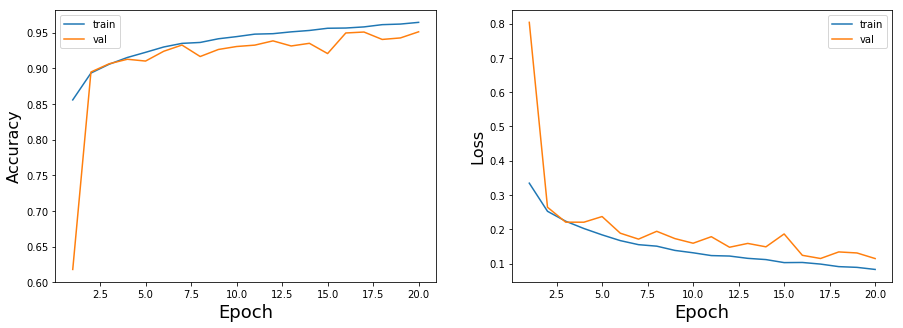

In [36]:
fig = plt.figure(figsize=(15, 5))
acc = fig.add_subplot(1, 2, 1)
acc.plot(range(1, 21), history.history['my_acc'], label='train')
acc.plot(range(1, 21), history.history['val_my_acc'], label='val')
acc.set_xlabel('Epoch', fontsize=18)
acc.set_ylabel('Accuracy', fontsize=16)
acc.legend()
loss = fig.add_subplot(1, 2, 2)
loss.plot(range(1, 21), history.history['loss'], label='train')
loss.plot(range(1, 21), history.history['val_loss'], label='val')
loss.set_xlabel('Epoch', fontsize=18)
loss.set_ylabel('Loss', fontsize=16)
loss.legend()
plt.show()

In [37]:
model_filepath = 'best.h5'

In [38]:
model.save(model_filepath)

In [28]:
model = load_model(model_filepath, custom_objects={'my_acc': my_acc, 'my_bce': my_bce})

Acc: 0.955


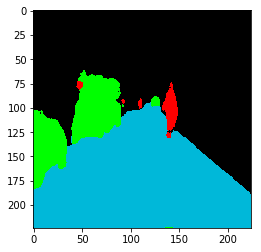

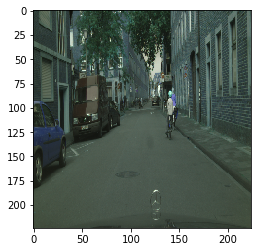

In [56]:
cls2col = {
    0: [0, 0, 0],
    1: [0, 184, 217],
    2: [0, 255, 0],
    3: [255, 0, 0]
}

def pred2human(img_pred):
    img_pred = np.argmax(img_pred, axis=2)
    img_pred = img_pred.astype(np.uint8)
    h, w = img_pred.shape[:2]
    result = np.zeros((h, w, 3), dtype=np.uint8)
    for k, v in cls2col.items():
        result[img_pred == k] = v
    return result

def get_acc(true, pred):
    total_count = np.prod(true.shape[:-1])
    total_count -= np.sum(true[:, :, :, -1] == 1)
    correct_count = np.sum(np.argmax(true, axis=3) == np.argmax(pred, axis=3))
    return correct_count / total_count

for x, y in val_batch_generator.get_batch():
    pred = model.predict(x)
    human = pred2human(pred[0, :, :, :])
    print('Acc: %.3f' % get_acc(y, pred))
    img = x[0, :, :, :]
    plt.imshow(human)
    plt.show()
    plt.imshow(img.astype(np.uint8))
    plt.show()
    break